# Projekt: Erkennung von Spurmarkierungen
In diesem Projekt sollen Spurmarkierungen in zwei bestehenden Datensätzen erkannt werden: 
1. Udacity Nanodegree "Self-Driving Car Engineer" (https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)
2. KITTI-Datensatz zur Erkennung von Spurmarkierungen (http://www.cvlibs.net/datasets/kitti/eval_road.php)

In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import glob

print('Willkommen beim Projekt "Erkennung von Spurmarkierungen"')

Willkommen beim Projekt "Erkennung von Spurmarkierungen"


# Import individual function files
For a better overview, the used functions have been separated into single Python files.

In [ ]:
from functions.Constants import *


# Exercise 1: Kamerakalibrierung zur Entzerrung der Bilder
Die vorhandenen Bilder sind aufgrund der Linsen- und Kameraeigenschaften verzerrt. Entzerren Sie die Bilder mithilfe der Kamerakalibrierungsroutinen von OpenCV (https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) und den aufgezeichneten Bildern.

In [3]:
# Reading a sample image
img1 = cv.cvtColor(cv.imread('./img/Udacity/calib/calibration1.jpg'), cv.COLOR_BGR2RGB)

# Calibration
# Initialize the calibration and calculate the parameters for the distortion correction of the image
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./img/Udacity/calib/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
h,  w = img1.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

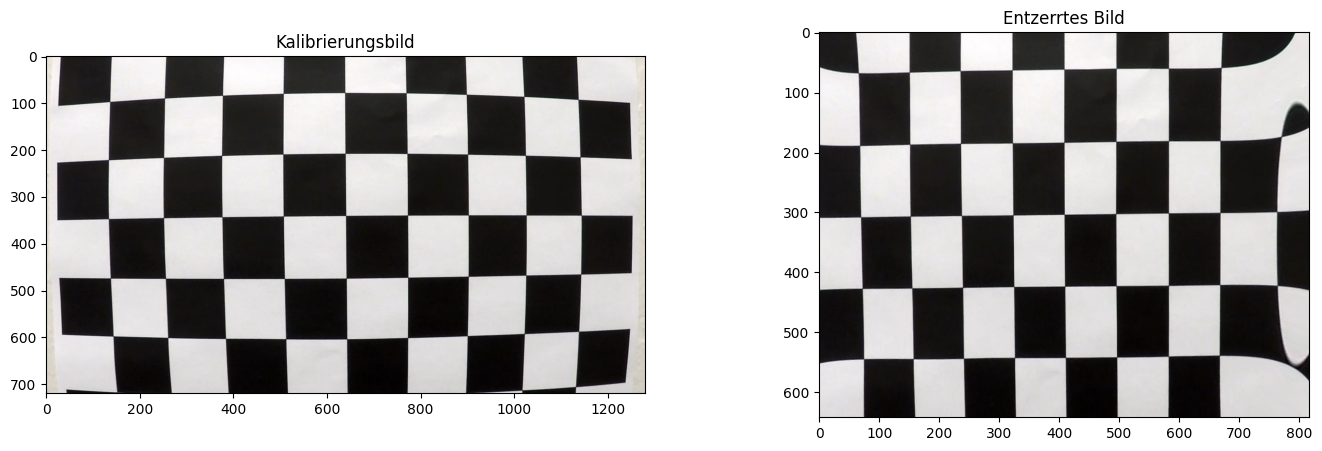

In [4]:
# Plot original image
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Kalibrierungsbild')

# Plot undistort image
dst = cv.undistort(img1, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('calibresult.png', dst)
plt.subplot(1,2,2)
plt.imshow(dst)
plt.title('Entzerrtes Bild')

plt.show()

# Exercise 2: Perspektivtransformation
Durch die Kameraperspektive wird die Krümmung der gefundenen Spurmarkierungen nicht der realen Fahrstreifenkrümmung entsprechen. Transformieren Sie daher die Bilder der Kameraperspektive in eine Vogelperspektive, die der realen Fahrstreifenkrümmung entspricht.

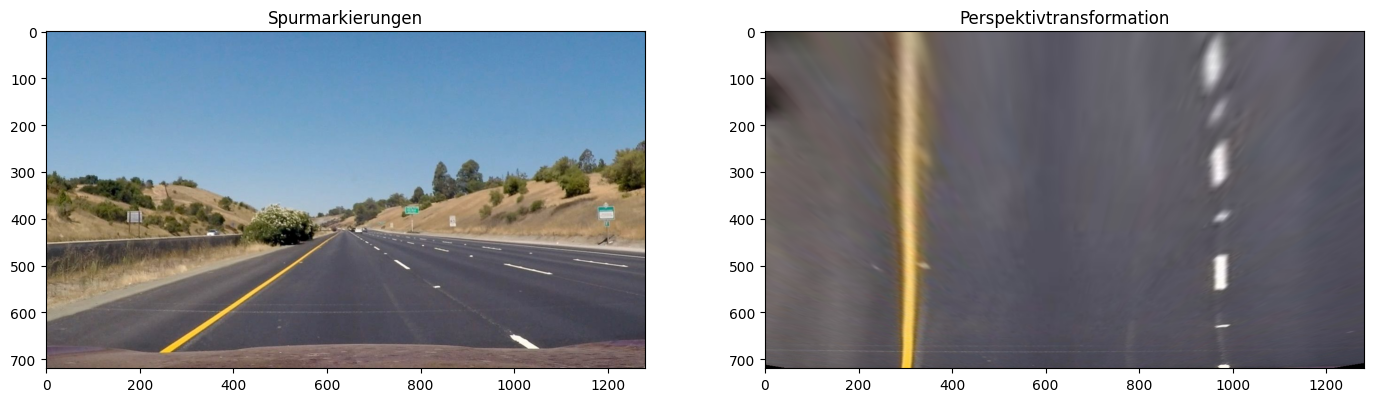

In [6]:
# einlesen eines Beispielbildes
img1 = cv.imread('./img/Udacity/image001.jpg', -1)
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Spurmarkierungen')

# definieren Sie die für eine Perspektivtransformation notwendigen Quell- und Zielpunkte [cools, rows]
src = np.float32([[598, 448], [684, 448], [1026, 668], [278, 668]])
dst = np.float32([[300, 0], [980, 0], [980, 720], [300, 720]])

M = cv.getPerspectiveTransform(src,dst)
img1_warp = cv.warpPerspective(img1,M,(img1.shape[1], img1.shape[0]))
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))
plt.title('Perspektivtransformation')
plt.show()

# Exercise 3: Erkennung von Fahrbahnmarkierungen
Erkennen Sie die Fahrbahnmarkierungen bzw. Fahrstreifen auf den Bildquellen von Udacity. Wenden Sie dabei die aus der Vorlesung bekannten Verfahren an. Gerne dürfen Sie auch weitere Verfahren aus anderen Quellen verwenden. Folgende Ziele müssen bei der finalen Abgabe erreicht werden: 
- **Segmentierung**: schränken Sie das Bild auf den Bereich ein, in dem sich die Spurmarkierungen befinden
- **Vorverarbeitung**: führen Sie eine Kamerakalibrierung (für Udacity-Bildquellen) und die Perspektivtransformation durch
- **Farbräume, Histogramme**: erkennen Sie die Spurmarkierungen in den Farben der angegebenen Quellen. Sofern weitere Spurmarkierungen auf dem Bild gefunden werden, müssen diejenigen Spurmarkierungen priorisiert werden, die die eigene Fahrspur begrenzen
- **Allgemeines**: Die Verarbeitung von Bildern muss in Echtzeit stattfinden --> Ziel: > 20 FPS
- **Allgemeines**: Beschleunigen Sie die Verarbeitung durch weitere Maßnahmen weitere Maßnahmen überlegen (bspw. Erkennung der Spurmarkierung in den ersten Frames, Tracking der Spurmarkierung in weiteren Frames solange, bis sich Spurmarkierungspositionen zu stark ändern)
- **Minimal**: relevante Spurmarkierungen werden im Video "project_video" durchgehend erkannt 
- **Zusatz**: relevante Spurmarkierungen werden im Video "challenge_video" und "harder_challenge_video" durchgehend erkannt
- **Zusatz**: relevante Spurmarkierungen werden auf den Datensatz KITTI angewendet. Welche Anpassungen müssen vorgenommen werden, damit Ihr Algorithmus übertragen werden kann?
- **Zusatz**: Erarbeiten Sie weitere Maßnahmen zur Geschwindigkeitsverbesserung Ihres Algorithmus
- **Zusatz**: Erkennen Sie Objekte im Bild und visualisieren Sie diese (z.B. weitere Fahrzeuge, Motorräder, etc.)Die Objekterkennung bitte so implementieren, dass sie deaktivierbar ist und nicht in FPS-Berechnung einzahlt.

### Real time lane detection in a video
Apply functions for lane detection on video (either project or challenge video)
Car detection can be manually turned on, by setting the variable `CAR_DETECTION` to **True**

Iterate through every frame from video:
- Calculate frame rate
- Calculate steps for lane detection only every fifth frame (for performance reasons):
    1. Perform perspective transform on image
    2. Apply color mask to detect yellow and white lanes and close image to reduce noise
    3. Apply sliding windows to find points for curve
    4. Calculate curve and radius
    5. Fill area and transform area image back
- Overlap area imgage on every frame to original
- Show curve radius and fps count

In [ ]:
# Open video file
video_file = 'project'
cap = cv.VideoCapture('./img/Udacity/' + video_file + '_video.mp4')

# Manually turn car detection on or off
CAR_DETECTION = False

# If challenge video is played -> Define different points for transformation 
CHALLENGE = (video_file == 'challenge') 
if(CHALLENGE):
  src = np.array([[600, 480], [760, 480], [1026, 700], [278, 700]], np.float32)
  dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Check if camera opened successfully
if (cap.isOpened() == False):
  print("Error opening video stream or file")

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
while(cap.isOpened()):
  ret, frame = cap.read()

  # Check if there is another frame
  if (frame is None):
    break
  orig = frame.copy()

  # Calculate Frame rate
  frame_count += 1
  ellapsed_time = time.time() - start_timer
  frame_rate = frame_count / ellapsed_time  

  # Calculate curve area only every fifth frame for performance reasons
  if (frame_count % 5 == 0):
    # Detect cars if car detection is on
    if (CAR_DETECTION):
      cars = detect_cars(frame)

    # Step 1: Warp image
    frame = warp(frame, src, dst)
   
    # Step 2: Apply color mask and close image for get rid of small distrubances
    color = color_space(frame)
    color = close(color, 10)

    # For challenge video: dilate and crop color mask
    if(CHALLENGE):
      color = dilate(color, 10)
      ROI = np.array([[(525, 360), (1150, 340), (1150, 720), (900, 720) , (700, 550), (350, 720), (115, 720)]], dtype=np.int32) 
      color = crop(color, ROI) 
    
    # Step 3: Sliding windows to get curve points    
    midpoint, lefts, rights = sliding_windows(color)

    # Step 4: Calculate curve and radius
    left_fit, right_fit, radius = calc_curve(lefts, rights, orig)
  
    # Step 5: Fill area and transform area back
    AOI = calc_area(frame, calc_lanes(left_fit, midpoint, True), calc_lanes(right_fit, midpoint, False), False)
    AOI = warp(AOI, dst, src)
  
  # Overlay street area on every image
  frame = overlay(orig, AOI)

  # If car detection is on: Draw rectangles around cars
  if (CAR_DETECTION):
    frame = highlight_cars(frame, cars)

  if ret == True:      
    # Add frame rate to video
    cv.putText(frame, "FPS: "+ str(round(frame_rate)), (0, 25), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv.LINE_AA)
    
    # Show curve radius (not for challenge video)
    if(not CHALLENGE):
      cv.putText(frame, "Curve radius: " + str(round(radius)).replace(".0", "") + "m", (len(frame[0])//2-150, 25), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2, cv.LINE_AA)
    cv.imshow('Frame', frame)

    # Close video with letter 'q'
    if cv.waitKey(25) & 0xFF == ord('q'):
      break
  else: 
    break

# When everything done, release the video capture object
cap.release()
cv.destroyAllWindows()

# Exercise 4: Objectdetection (Bonus task 1)


# Exercise 5: License plate recognition (Bonus task 2)

# Exercise 6: Port to Java app for Android smartphones (App)
A separate GitHub repo has been created for the app, which can be accessed via this [link](https://github.com/JoDi-2903/Road-Lane-Detection).